In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from IPython.display import clear_output

In [2]:
with open('t8.shakespeare.txt') as file:
    raw_lines = [line.replace('\r',' ') for line in file.readlines()]
raw_text = ' '.join(raw_lines[300:-300])

In [3]:
vocab = list(set(raw_text))
trans_dic = {vocab[i]: i for i in range(len(vocab))}
rev_trans_dic = {i: vocab[i] for i in range(len(vocab))}
raw_text_enc = [trans_dic[letter] for letter in raw_text]

In [13]:
text_size = len(raw_text_enc)
vocab_size = len(vocab)
num_neurons = 100
num_steps = 1
batch_size = 1

In [5]:
def gen_batch(raw_x, batch_size, num_steps):

    if batch_size % num_steps != 0:
        warnings.warn("Warning: batch size is not a multiple of num_steps.")
    
    raw_y = raw_x[1:] + [raw_x[0]]
    
    # partition raw data into batches and stack them vertically in a data matrix
    num_batch = len(raw_x) // batch_size
    data_x = np.zeros([num_batch, batch_size], dtype=np.int32)
    data_y = np.zeros([num_batch, batch_size], dtype=np.int32)
    
    for i in range(num_batch):
        data_x[i] = raw_x[batch_size * i:batch_size * (i + 1)]
        data_y[i] = raw_y[batch_size * i:batch_size * (i + 1)]
    
    # further divide batch partitions into num_steps for truncated backprop
    batch_lines = batch_size // num_steps

    for i in range(num_batch):
        x = np.zeros([batch_lines,num_steps],dtype=np.int32)
        y = np.zeros([batch_lines,num_steps],dtype=np.int32)
        for n in range(batch_lines):
            x[n,:] = data_x[i, n * num_steps:(n + 1) * num_steps]
            y[n,:] = data_y[i, n * num_steps:(n + 1) * num_steps]
        yield (x, y)

In [6]:
def gen_epochs(raw_data, num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(raw_data,batch_size,num_steps)

# Graph 

In [14]:
tf.reset_default_graph()

In [15]:
#----------input layer-----------------------
x = tf.placeholder(tf.int64, [None, num_steps])
y = tf.placeholder(tf.int64, [None, num_steps])
#init_state = tf.placeholder(tf.float32,[None, num_neurons])
learning_rate = tf.placeholder(tf.float32,[])

embeddings = tf.get_variable('embedding_matrix', [vocab_size, num_neurons])

# Tensor of dims batch_size //num_steps x num_steps x num_neurons
x_transformed = tf.nn.embedding_lookup(embeddings, x)


#----------hidden layer-----------------------
cell = tf.nn.rnn_cell.BasicRNNCell(num_neurons)
init_state = cell.zero_state(batch_size//num_steps,tf.float32)
rnn_output, final_state = tf.nn.dynamic_rnn(cell, x_transformed, initial_state=init_state, dtype=tf.float32)


#----------output layer-----------------------
weight = tf.Variable(tf.truncated_normal([num_neurons, vocab_size], stddev=0.1))
bias = tf.Variable(tf.constant(0.0, shape=[vocab_size]))

output = tf.reshape(rnn_output, [-1, num_neurons])
logits = tf.matmul(output, weight) + bias
prediction = tf.nn.softmax(logits)
prediction = tf.reshape(prediction, [-1, num_steps, vocab_size])

#----------loss and accuracy------------------
target = tf.reshape(y,[-1])
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,target))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 2),y), tf.float32))

#----------Trainer------------------
trainOp = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
init_vars = tf.initialize_all_variables()


# Training

In [9]:
print_after_num_steps = 10
adaptive_learning_rate = 0.01
training_state = None

trainHist = []
accHist = []

sess = tf.Session()
sess.run(init_vars)

for num_epoch, epoch in enumerate(gen_epochs(raw_text_enc,1,batch_size,num_steps)):
    
    #if num_epoch > 300:
    #    adaptive_learning_rate = 0.001
    
    for i, batch in enumerate(epoch):
        
        feed_dic = {x: batch[0], y: batch[1], learning_rate: adaptive_learning_rate}
        if training_state is not None:
            feed_dict = {x: batch[0], y: batch[1],init_state: training_state,  learning_rate: adaptive_learning_rate}
        
        acc, lossVal, training_state, _ = sess.run([accuracy, loss, final_state, trainOp], feed_dict=feed_dic)
        trainHist.append(lossVal)
        accHist.append(acc)
        
        if i % print_after_num_steps == 0:
            clear_output()
            avg_loss = sum(trainHist[-print_after_num_steps:])/print_after_num_steps
            avg_acc = sum(accHist[-print_after_num_steps:])/print_after_num_steps
            
            print(num_epoch, i, avg_loss, avg_acc)
            

(0, 210, 1.8538309335708618, 0.46717187464237214)


In [12]:
saver = tf.train.Saver()
saver.save(sess, 'basic_rnn_save.tf_vars')

'basic_rnn_save.tf_vars'

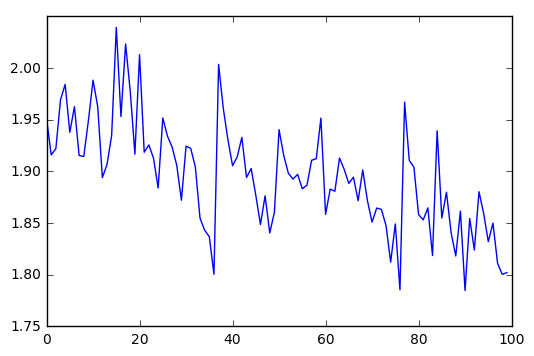

In [11]:
plt.plot(trainHist[-100:])

In [47]:
#rebuild the graph before
sess = tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
saver.restore(sess, 'basic_rnn_save.tf_vars')
prev = np.array([[trans_dic['x']]])
last_state = None
digital_shakespeare = ''
pred_hist = []

for i in range(1000):
    if i == 0:
        pred, last_state = sess.run([prediction,final_state],feed_dict={x: prev})
    else:
        pred, last_state = sess.run([prediction,final_state],feed_dict={x: prev, init_state: last_state})
    
    pred_hist.append(pred)
    prev = rev_trans_dic[np.random.choice(vocab_size,1,p=np.squeeze(pred)).flatten()[0]]
    digital_shakespeare += prev
    prev = np.array([[trans_dic[prev]]])

In [48]:
print(digital_shakespeare)

erard tixe wifiettebender with rard.
     I gay fair! to winlen
     Thie;- therefering cree leve wither mess dide the hast; I bet him,
     Withilf; untled arghing aresine collins me withight
     To the mould hind of are graad a will and truck my
     Begrane thundes wan perter to ment on be offer reen thee chy, uthingonew, learger. Bet to granat,     Fore hir.

   Pave, thin soor his of the himint what they have breever.
   A' word of goor my the with unclece.
     The prom
   ALOL TUTFAT DILITETEN.
     I tour of sen  Peak with will tore bear to the grow there nedg.
   A musogh the
     EJIE. Here trupted you.
     Tame's enende's out's nove, youch thery one pith wifa.
     Cown'd.
     will she hen
   Duptane
   Have your will groble she swever with not us a then whteed yoush are mosease thy will to apreers for tare sing what pedas'tt.
   renter esa ener as ollar pabon, and or you, whis fas lostiren, be bus'd: to thy;
   PLOBY. If For what and nome that as she these thee, grees fo

In [43]:
np.random.choice(vocab_size,1,p=np.squeeze(pred_hist[45]))

array([63])

In [ ]:
prev = np.random.choice(vocab_size,num_steps).astype(np.float32).reshape(1,num_steps)
last_state = np.zeros((1, num_neurons),dtype=np.float32)

digital_shakespeare = []

def my_func(prob_array):
    choice_char = rev_trans_dic[np.random.choice(a = range(vocab_size), p = prob_array)]
    return choice_char

for i in range(10):
    pre_pred, last_state = sess.run([pre_prediction,final_state],feed_dict={x: prev, init_state: last_state})
    #prev = np.argmax(pred,axis=2)
    digital_shakespeare += "".join(np.apply_along_axis(my_func, 1, pre_pred).flatten().tolist())